# Ames, Iowa : Predicting Sales Prices - Descision Tree and Random Forest modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,\
MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer
from LR_helper import cat_column_combine_vars, num_new_features,\
label_encode_features, model_results, cat_new_features, std_num_cols
from clean_helper import dtype_update
from dtree_rf_helper import tree_label_encode, tree_model_res
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

### Loading cleaned training and testing datasets:-

In [2]:
train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)
print(train_df.shape)
print(test_df.shape)

(1453, 80)
(1457, 79)


### Creating new numerical variables, combining variables and creating new categorical variables:-

In [3]:
# Creating new numerical variable features:-
num_new_features(train_df)
num_new_features(test_df)

# Combining categories in some categorical features:-
cat_column_combine_vars(train_df)
cat_column_combine_vars(test_df)

# Creating new categorical variable features:-
cat_new_features(train_df)
cat_new_features(test_df)

### Label encoding all categorical features (all dataframes):

In [4]:
# Label encoding via helper functions:

tree_label_encode(train_df)
tree_label_encode(test_df)

### Standardizing numerical columns:

In [5]:
# Standardizing via helper functions:

std_num_cols(train_df)
std_num_cols(test_df)

## Random Forest Models:-

In [6]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)

### Base Model:

In [7]:
rf_base = RandomForestRegressor(random_state=0)
tree_model_res(trainX, trainY, testX, testY, rf_base, show = True)

Train R^2 is equal to 0.982
Test R^2 is equal to 0.903
Train RMSE is equal to 10486.283
Test RMSE is equal to 22779.161
The training error is: 0.01800
The test     error is: 0.09693


[0.018000751928314518, 0.09692926001824986]

### Model with Box-Cox transformed y variable:

In [8]:
#Transforming variables

trfm = PowerTransformer(method='box-cox')
trainY_trans = trfm.fit_transform(pd.DataFrame(trainY))
testY_trans = trfm.fit_transform(pd.DataFrame(testY))

rf_BCy = RandomForestRegressor(random_state=0)
tree_model_res(trainX, trainY_trans, testX, testY_trans, rf_BCy, show = True)

Train R^2 is equal to 0.982
Test R^2 is equal to 0.889
Train RMSE is equal to 0.136
Test RMSE is equal to 0.334
The training error is: 0.01844
The test     error is: 0.11125


[0.018443378737350802, 0.11124795851942704]

### Model with Log transformed x and y variables and oob score feature turned on:

In [10]:
#Transforming variables

trfm = FunctionTransformer(func=np.log1p)
trainX_trans = trfm.fit_transform(trainX)
testX_trans = trfm.fit_transform(testX)

rf_log = RandomForestRegressor(random_state=0)
rf_log.set_params(random_state=42, oob_score=True)
tree_model_res(trainX_trans, np.log(trainY), testX_trans, np.log(testY), rf_log, show = True)

Train R^2 is equal to 0.982
Test R^2 is equal to 0.888
Train RMSE is equal to 0.053
Test RMSE is equal to 0.130
The training error is: 0.01798
The test     error is: 0.11199


[0.017975394766618802, 0.11199004561367876]

In [12]:
# Out of bag error:

rf_log.oob_score_

0.8679377662096854

## Plotting errors and R^2 values for different number of trees in the random forest:

In [15]:
trees_range = range(30, 500, 10)  
train_error = []
test_error = []
oob_error = []
train_r2 = []
test_r2 = []

for n_trees in trees_range:
    rf_log.set_params(n_estimators=n_trees, random_state=0, oob_score=True)
    rf_log.fit(trainX_trans, np.log(trainY))
    train_error.append(1 - rf_log.score(trainX_trans, np.log(trainY)))
    test_error.append(1 - rf_log.score(testX_trans, np.log(testY)))
    train_r2.append(rf_log.score(trainX_trans, np.log(trainY)))
    test_r2.append(rf_log.score(testX_trans, np.log(testY)))
    oob_error.append(1 - rf_log.oob_score_)

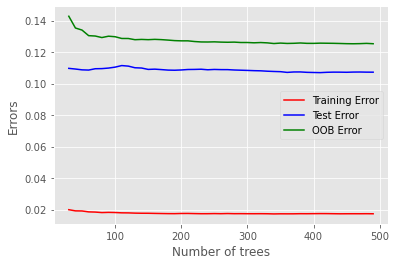

In [16]:
plt.plot(trees_range, train_error, c='red', label='Training Error')
plt.plot(trees_range, test_error, c='blue', label='Test Error')
plt.plot(trees_range, oob_error, c='green', label='OOB Error')
plt.ylabel('Errors')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

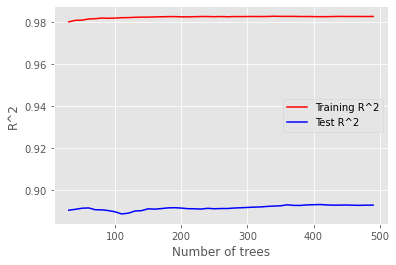

In [18]:
plt.plot(trees_range, train_r2, c='red', label='Training R^2')
plt.plot(trees_range, test_r2, c='blue', label='Test R^2')
plt.ylabel('R^2')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

## Using Grid Search to find best parameters

In [21]:
depth_range = range(3, 20)
train_error = []
test_error = []
oob_error = []
train_r2 = []
test_r2 = []

for depth in depth_range:
    rf_log.set_params(max_depth=depth, random_state=0, oob_score=True)
    rf_log.fit(trainX_trans, np.log(trainY))
    train_error.append(1 - rf_log.score(trainX_trans, np.log(trainY)))
    test_error.append(1 - rf_log.score(testX_trans, np.log(testY)))
    train_r2.append(rf_log.score(trainX_trans, np.log(trainY)))
    test_r2.append(rf_log.score(testX_trans, np.log(testY)))
    oob_error.append(1 - rf_log.oob_score_)

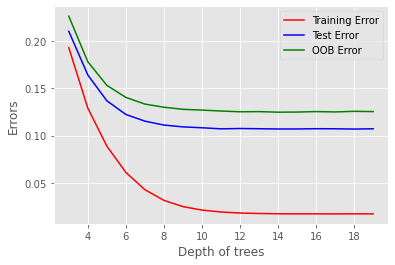

In [23]:
plt.plot(depth_range, train_error, c='red', label='Training Error')
plt.plot(depth_range, test_error, c='blue', label='Test Error')
plt.plot(depth_range, oob_error, c='green', label='OOB Error')
plt.ylabel('Errors')
plt.xlabel('Depth of trees')
plt.legend()
plt.show()

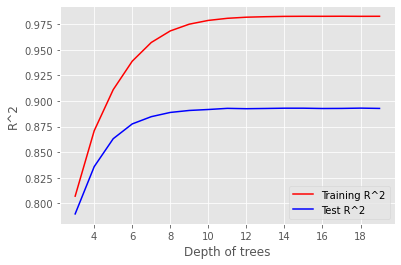

In [24]:
plt.plot(depth_range, train_r2, c='red', label='Training R^2')
plt.plot(depth_range, test_r2, c='blue', label='Test R^2')
plt.ylabel('R^2')
plt.xlabel('Depth of trees')
plt.legend()
plt.show()